# Proxy

In [1]:
# pip install nb_mypy
%load_ext nb_mypy

Version 1.0.5


In [2]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

from typing import Any, Tuple, List, Dict, Set

Allostery:
<div>
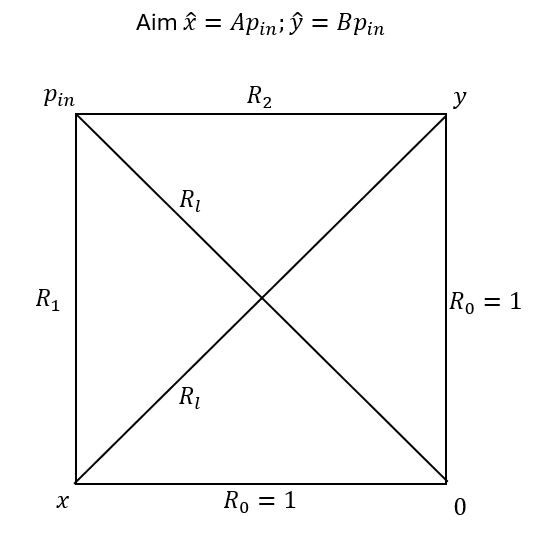
</div>


In [3]:
## Ugly Classes

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif variabs.task_type == 'General_reg':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, \
            self.R4, self.R5, self.R6, self.p1, self.p2 = sp.symbols('x, y, z, R1, R2, R3, R4, R5, R6, p1, p2') 
        elif variabs.task_type == 'General_reg_allRsChange':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, self.R4, self.R5, self.R6, self.R7, self.R8, self.R9, \
            self.R10, self.R11, self.R12, self.R13, self.R14, self.R15, self.p1, self.p2 = sp.symbols('x y z R1 R2 R3 R4 R5 R6 R7 R8 R9 R10 R11 R12 R13 R14 R15 p1 p2')


In [4]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma, use_p_tag=True, R_update: str = 'propto'):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma
        self.use_p_tag = use_p_tag 
        self.R_update = R_update  # 'propto' if R=gamma*delta_p
                                  # 'deltaR' if deltaR=gamma*delta_p, gamma should be small


class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        # inital resistance, out_dual and p_in
        if self.variabs.task_type == 'Allostery':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
        elif self.variabs.task_type == 'Regression':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
        elif self.variabs.task_type == 'General_reg':
            self.R_in_t = [np.array([1.,1.,1.,1.,1.,1.])]
            # self.R_in_t = [np.array([18.7,2.4,4.0,-13.5,-12.8,1.5])]  # theoretical one
            # self.R_in_t = [np.array([13.8,7.3,-1.5,-8.0,-2.4,-8.9])]  # solved using pinv as in matlab code
                                                                        # "Calculate_desired_resistances_GeneralReg2024.m"
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
        elif self.variabs.task_type == 'General_reg_allRsChange':
            self.R_in_t = [np.ones((15), dtype=float)]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
            
        # initalized drawn sample vec and loss func
        if self.variabs.task_type == 'Allostery':
            self.loss_fn = loss_fn_allostery
        else:
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
        elif self.variabs.task_type == 'General_reg':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2 + syms.p2**2 + syms.x**2 + syms.y**2 + syms.z**2 + (syms.p1-syms.p2)**2 + \
                     (syms.x-syms.y)**2 + (syms.y-syms.z)**2 + (syms.x-syms.z)**2
        elif self.variabs.task_type == 'General_reg_allRsChange':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2/syms.R7 + syms.p2**2/syms.R8 + syms.x**2/syms.R9 + syms.y**2/syms.R10 + \
                     syms.z**2/syms.R11 + (syms.p1-syms.p2)**2/syms.R12 + (syms.x-syms.y)**2/syms.R13 + \
                     (syms.y-syms.z)**2/syms.R14 + (syms.x-syms.z)**2/syms.R15
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
        elif self.variabs.task_type == 'General_reg' or self.variabs.task_type == 'General_reg_allRsChange':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            dPdz = self.P.diff(syms.z)
            sols = sp.solve([dPdx,dPdy,dPdz],[syms.x,syms.y,syms.z])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
            self.z = sols[syms.z]
    
    def calc_output(self, syms):
        # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
        if self.variabs.task_type == 'Allostery':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        elif self.variabs.task_type == 'General_reg':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
        elif self.variabs.task_type == 'General_reg_allRsChange':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
            
        # display and save output in time
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if type(output_prev)==int and type(desired)!=np.float64:  # if desired not scalar, must change other sizes as well
            output_prev = np.zeros(len(desired))
            desired_prev = np.zeros(len(desired))
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg' \
             or self.variabs.task_type=='General_reg_allRsChange':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':     
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression' or self.variabs.task_type=='General_reg' \
             or self.variabs.task_type=='General_reg_allRsChange':
            p_drawn = self.p_drawn_in_t[-1]
            if self.variabs.use_p_tag:
                p_drawn_prev = self.p_drawn_in_t[-2]
                p_nxt = p - (p_drawn-p_drawn_prev)*np.dot(self.variabs.alpha, loss[0]-loss[1])
#             p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1]))
#             print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1])))
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]-loss[1]))
            else:
                p_nxt = p - (p_drawn)*np.dot(self.variabs.alpha, loss[0])          
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]))            
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        
        # pressure changes without memory?
        if self.variabs.R_update == 'deltaR' and np.shape(self.p_in_t)[0]>1:  # make sure its not initial value
            p_nxt -= p  # erase memory
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg' \
        or self.variabs.task_type=='General_reg_allRsChange':
            # self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            self.output = out_dual + self.variabs.alpha * (self.output-self.out_in_t[-2])*(loss[0]-loss[1])
        
        # BCs change without memory?
        if self.variabs.R_update == 'deltaR' and np.shape(self.out_dual_in_t)[0]>1:  # make sure its not initial value
            self.output -= out_dual  # erase memory
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        if self.variabs.task_type=='Allostery' or self.variabs.task_type=='Regression':
            self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        elif self.variabs.task_type=='General_reg':
            R_ij = []
            print(self.p_in_t[-1])
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            self.R_in_t.append(R_ij)
            # self.R_in_t.append(self.R_in_t[0])
        elif self.variabs.task_type=='General_reg_allRsChange':
            R_ij = []
            # inputs to outputs
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            # input to ground
            for i, p in enumerate(self.p_in_t[-1]):
                R_ij.append(self.variabs.gamma[i] * (p - 0))
            # outputs to ground
            for j, out, in enumerate(self.output):
                R_ij.append(self.variabs.gamma[j] * (out - 0))
            # inputs between themselves
            R_ij.append(self.variabs.gamma[0] * (self.p_in_t[-1][0] - self.p_in_t[-1][1]))
            # outputs between themselves
            for i, out in enumerate(self.output):
                R_ij.append(self.variabs.gamma[0] * (self.output[i] - self.output[(i+1)%3]))
            self.R_in_t.append(R_ij)
        
        # if deltaR=gamma*delta_p
        if self.variabs.R_update == 'deltaR' and np.shape(self.R_in_t)[0]>1:  # make sure its not initial value
            print('update is deltaR')
            self.R_in_t[-1] += self.R_in_t[-2]  # update previous value [-2], gamma should be small
            
        # optionally display resistances
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [52]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0, use_p_tag=True, R_update: str ='propto'):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        print('alpha_vec', alpha_vec)
        # gamma = np.array([0.5, 0.5])  # how much resistance changed due to pressure difference
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    elif task_type=='General_reg' or task_type=='General_reg_allRsChange':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec, alpha_vec))
        print(alpha_vec)
        gamma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # how much resistance changed due to pressure difference
        A = 0.05
        B = 0.25
        C = 0.1
        D = 0.15
        E = 0.02
        F = 0.3
        M = np.array([[A, B],  
                      [C, D], 
                      [E, F]])  # this is in terms of M matrix, desired press. is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma, use_p_tag=use_p_tag, R_update=R_update)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression' or task_type=='General_reg' or task_type=='General_reg_allRsChange':
                if task_type=='Regression' and np.size(alpha)>1 :
                    state.update_alpha(alpha(i))
                state.draw_p()
                if task_type=='Regression':
                    desired = np.dot(AB_vec, state.p_drawn)
                else:
                    desired = np.matmul(M, state.p_drawn)
                state.desired_in_t.append(desired)
                if supress:
                    pass
                else:
                    print('p_drawn', state.p_drawn)
                    print('desired', desired)
                state.calc_output(syms)
                if not i % 2:  # even iterations
                    pass
                else:
                    if use_p_tag:
                        state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    else:
                        state.calc_loss(desired)
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired


def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$p\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$', r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
#         C = desired[2]/state.p_in_t[0]  # B = y_hat/p_in
#         D = desired[3]/state.p_in_t[0]  # B = y_hat/p_in
#         E = desired[4]/state.p_in_t[0]  # B = y_hat/p_in
#         F = desired[5]/state.p_in_t[0]  # B = y_hat/p_in
        # R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        # legend1 = ['x', 'y', 'z', 'x desired', 'y deisred', 'z desired']
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$', \
                   r'$\frac{z}{z\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$z\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$',
                   r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_3$', r'$R_4$', r'$R_5$', r'$R_6$']
        R_theor = []  # I didn't calculate it for this task
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3.2))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:]/desired-1)
        ax1.plot(np.zeros(len(state.out_in_t[1:])), '--')
    # regression goes only every two samples
    elif variabs.task_type=='Regression' or variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, \
                 np.asarray(state.out_in_t[1:])/np.asarray(state.desired_in_t[1:])-1)
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    if variabs.task_type=='Allostery' or variabs.task_type=='Regression':  # loss is 2D in Allostery
        ax4.plot(np.abs(state.loss_in_t[1:]))
    elif variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':    
        ax4.plot(np.mean(np.mean(np.abs(state.loss_in_t[1:]), axis=1),axis=1))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [55]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([1.0])  # for allostery, regression and general_reg
alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
# task_type: str =  'Allostery'
# task_type: str = 'Regression'
# task_type: str = 'General_reg'
task_type: str = 'General_reg_allRsChange'

R_update = 'propto'
# R_update = 'deltaR'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training: int = len(alpha_vec[0])
else:
    training = 320

[[0.1 0.1 0.1]]
p_drawn [0.14653972 0.71811705]
desired [0.18685625 0.12237153 0.21836591]
output= [0.288218921822252 0.288218921822252 0.288218921822252]
p_drawn [1.14071856 0.48296308]
desired [0.1777767  0.18651632 0.1677033 ]
output= [0.541227214006832 0.541227214006832 0.541227214006832]
the dot for p -0.0754622249004679
loss= [[-0.363450515865455 -0.354710895794694 -0.373523918709929]
 [-0.101362674502873 -0.165847393014066 -0.0698530138484598]]
time= 1
p_nxt= [1.07502294733476 0.982254758604787]
dual output [0.493368960285451 0.495221596770548 0.492316874297485]
R_nxt [0.581653987049310, 0.579801350564214, 0.582706073037276, 0.488885798319336, 0.487033161834239, 0.489937884307302, 1.07502294733476, 0.982254758604787, 0.493368960285451, 0.495221596770548, 0.492316874297485, 0.0927681887299745, -0.00185263648509654, 0.00290472247306223, -0.00105208598796569]
p_drawn [1.52329611 1.33006853]
desired [0.40868194 0.35183989 0.42948648]
output= [0.928047836054467 0.912536775868714 0.93

output= [0.354246754441710 0.343691173639555 0.426168941865419]
p_drawn [0.22079598 1.68955182]
desired [0.43342775 0.27551237 0.51128147]
output= [0.575949827080371 0.576394907558415 0.553546275695778]
the dot for p 0.00692757171593151
loss= [[-0.142522072587546 -0.300882536118719 -0.0422648095866740]
 [-0.159402016283729 -0.171725906223238 -0.223817212945287]]
time= 11
p_nxt= [1.59630708149330 0.973878867183808]
dual output [0.451963293963092 0.452892680819208 0.422353169825170]
R_nxt [1.14434378753021, 1.14341440067409, 1.17395391166813, 0.521915573220715, 0.520986186364599, 0.551525697358638, 1.59630708149330, 0.973878867183808, 0.451963293963092, 0.452892680819208, 0.422353169825170, 0.622428214309491, -0.000929386856116210, 0.0305395109940387, -0.0296101241379225]
p_drawn [1.02469729 0.63209134]
desired [0.2092577  0.19728343 0.21012135]
output= [0.397695327012631 0.394063055114265 0.509657944465731]
p_drawn [1.68838519 1.03470282]
desired [0.34309497 0.32404394 0.34417855]
outpu

output= [0.213764812930161 0.244548511388388 0.336891577138572]
p_drawn [1.48635142 0.65294249]
desired [0.23755319 0.24657652 0.22560977]
output= [0.379396289117212 0.428402442242742 0.572230147658183]
the dot for p -0.0245005147579518
loss= [[-0.141843095811386 -0.181825926547050 -0.346620372669590]
 [-0.0920350846674168 -0.103663373060572 -0.229585789720519]]
time= 21
p_nxt= [1.97700040944705 1.06803492316608]
dual output [0.427071644078644 0.412650694886994 0.370962707379498]
R_nxt [1.54992876536840, 1.56434971456005, 1.60603770206755, 0.640963279087436, 0.655384228279086, 0.697072215786582, 1.97700040944705, 1.06803492316608, 0.427071644078644, 0.412650694886994, 0.370962707379498, 0.908965486280965, 0.0144209491916503, 0.0416879875074957, -0.0561089366991460]
p_drawn [1.27707507 0.66758913]
desired [0.23075104 0.22784588 0.22581824]
output= [0.350376080841494 0.392982840545163 0.515042534507875]
p_drawn [0.39777918 0.21902055]
desired [0.0746441  0.072631   0.07366175]
output= [0

output= [0.0977366113948185 0.114292000177257 0.125467871115744]
p_drawn [1.75266488 1.31050113]
desired [0.41525853 0.37184166 0.42820364]
output= [0.505743214158523 0.608060290391883 0.699719816152518]
the dot for p -0.0582304918908673
loss= [[-0.0904846884274655 -0.236218633420694 -0.271516180436709]
 [0.0163662145273909 -0.0409443355885767 0.00866353768499079]]
time= 31
p_nxt= [2.20109425309451 1.24444117477561]
dual output [0.417774842243823 0.373459788486626 0.332371837033650]
R_nxt [1.78331941085069, 1.82763446460788, 1.86872241606086, 0.826666332531787, 0.870981386288983, 0.912069337741960, 2.20109425309451, 1.24444117477561, 0.417774842243823, 0.373459788486626, 0.332371837033650, 0.956653078318900, 0.0443150537571962, 0.0410879514529767, -0.0854030052101730]
p_drawn [1.2210541 1.6394422]
desired [0.47091325 0.36802174 0.51625374]
output= [0.475390877391664 0.557241022279967 0.626053977298346]
p_drawn [1.33060042 0.46395512]
desired [0.1825188  0.20265331 0.16579855]
output= [

output= [0.265183590512086 0.322060257402649 0.346857088833731]
p_drawn [1.13958952 0.88304722]
desired [0.27774128 0.24641603 0.28770596]
output= [0.284966549861978 0.354098470115136 0.379430557461754]
the dot for p 0.0113706305186047
loss= [[-0.00722527011595553 -0.107682436208361 -0.0917246023717627]
 [-0.0610005667570327 -0.101434111661174 -0.157903935463920]]
time= 41
p_nxt= [2.46657341331017 1.29573199698035]
dual output [0.420609802194428 0.336102035090946 0.308398485540311]
R_nxt [2.04596361111574, 2.13047137821922, 2.15817492776986, 0.875122194785919, 0.959629961889401, 0.987333511440036, 2.46657341331017, 1.29573199698035, 0.420609802194428, 0.336102035090946, 0.308398485540311, 1.17084141632982, 0.0845077671034816, 0.0277035495506352, -0.112211316654117]
p_drawn [1.40033654 1.42492152]
desired [0.42624721 0.35377188 0.45548319]
output= [0.402500600937036 0.506471062282762 0.541751966339256]
p_drawn [0.59168775 0.23140932]
desired [0.08743672 0.09388017 0.08125655]
output= [0

output= [0.257505870588419 0.302802139410537 0.318762156815959]
p_drawn [1.71220334 1.21649088]
desired [0.38973289 0.35369397 0.39919133]
output= [0.399001602843862 0.487647565247898 0.512001605004812]
the dot for p 0.00440030447116471
loss= [[-0.00926871532917684 -0.133953599224624 -0.112810273424025]
 [-0.0662831737531461 -0.0863095610071266 -0.147442897929201]]
time= 51
p_nxt= [2.55754312372129 1.33427704971567]
dual output [0.422320227666646 0.320700433112919 0.299403291505681]
R_nxt [2.13522289605465, 2.23684269060837, 2.25813983221561, 0.911956822049022, 1.01357661660275, 1.03487375820999, 2.55754312372129, 1.33427704971567, 0.422320227666646, 0.320700433112919, 0.299403291505681, 1.22326607400562, 0.101619794553727, 0.0212971416072382, -0.122916936160965]
p_drawn [1.492343   1.25238003]
desired [0.38771216 0.3370913  0.40556087]
output= [0.376466552349529 0.464953202431826 0.486296091812268]
p_drawn [0.55618069 1.57215354]
desired [0.42084742 0.2914411  0.48276968]
output= [0.3

output= [0.214799096031168 0.284572988377583 0.285303272344300]
p_drawn [0.40884346 0.9078071 ]
desired [0.24739395 0.17705541 0.280519  ]
output= [0.177874652751569 0.266632075064205 0.267333659796237]
the dot for p 0.0156191270452946
loss= [[0.0695192937923279 -0.0895766652534566 0.0131853378367760]
 [-0.00246004620053508 -0.0940232277959178 -0.0665800300808457]]
time= 61
p_nxt= [2.67337532204070 1.21228949808948]
dual output [0.430408727903899 0.307897965561367 0.306777517836320]
R_nxt [2.24296659413680, 2.36547735647933, 2.36659780420438, 0.781880770185578, 0.904391532528110, 0.905511980253157, 2.67337532204070, 1.21228949808948, 0.430408727903899, 0.307897965561367, 0.306777517836320, 1.46108582395122, 0.122510762342532, 0.00112044772504671, -0.123631210067579]
p_drawn [0.19267925 0.88278225]
desired [0.23032952 0.15168526 0.26868826]
output= [0.144037622856493 0.229761657350716 0.230463539669250]
p_drawn [1.12707328 0.19582218]
desired [0.10530921 0.14208065 0.08128812]
output= [

output= [0.291505279161473 0.345445380830440 0.334627074629929]
p_drawn [1.77871793 0.62197029]
desired [0.24442847 0.27116734 0.22216545]
output= [0.313205521058482 0.408510773655146 0.395589946746500]
the dot for p 0.00576685343740201
loss= [[-0.0687770509119920 -0.137343436225910 -0.173424499908621]
 [-0.120904817512646 -0.110824955810450 -0.205483748097447]]
time= 71
p_nxt= [2.98695222318795 1.10654282384041]
dual output [0.427036300614953 0.288153922942902 0.298599433558285]
R_nxt [2.55991592257300, 2.69879830024505, 2.68835278962967, 0.679506523225455, 0.818388900897506, 0.807943390282123, 2.98695222318795, 1.10654282384041, 0.427036300614953, 0.288153922942902, 0.298599433558285, 1.88040939934754, 0.138882377672051, -0.0104455106153836, -0.128436867056668]
p_drawn [1.4184259  1.24825399]
desired [0.38298479 0.32908069 0.40284471]
output= [0.337188334932908 0.513578225988933 0.496503983171896]
p_drawn [0.47982467 0.93459012]
desired [0.25763876 0.18817099 0.28997353]
output= [0.1

output= [0.382239694466103 0.516433235969145 0.477040965611803]
p_drawn [0.76722694 1.75435624]
desired [0.47695041 0.33987613 0.54165141]
output= [0.312604942305057 0.538595390741130 0.493829468321919]
the dot for p 0.0266928336391568
loss= [[0.164345463448962 -0.198719261529042 0.0478219410059462]
 [0.00107919468794804 -0.172246672260037 -0.0823127158936136]]
time= 81
p_nxt= [3.08738793056486 1.09918488146737]
dual output [0.431856633053481 0.265783158531228 0.295713367292846]
R_nxt [2.65553129751138, 2.82160477203363, 2.79167456327201, 0.667328248413892, 0.833401722936145, 0.803471514174527, 3.08738793056486, 1.09918488146737, 0.431856633053481, 0.265783158531228, 0.295713367292846, 1.98820304909749, 0.166073474522253, -0.0299302087616183, -0.136143265760635]
p_drawn [0.23269257 0.21473346]
desired [0.06531799 0.05547928 0.06907389]
output= [0.0590753011980270 0.0852506357772388 0.0783212238008571]
p_drawn [0.54138222 0.00434626]
desired [0.02815568 0.05479016 0.01213152]
output= [0

output= [0.200543278623221 0.383410619957986 0.323388684582821]
p_drawn [1.08824844 1.63017423]
desired [0.46195598 0.35335098 0.51081724]
output= [0.375918987859232 0.577576003273070 0.495485678645284]
the dot for p -0.0154689796907861
loss= [[0.0860369924072298 -0.224225024301150 0.0153315600675883]
 [0.131395583153630 -0.161504080594333 0.0619418225222322]]
time= 91
p_nxt= [3.19337360613986 1.04936631796958]
dual output [0.433570201460308 0.244938337408162 0.299607794935527]
R_nxt [2.75980340467955, 2.94843526873169, 2.89376581120433, 0.615796116509270, 0.804427980561416, 0.749758523034051, 3.19337360613986, 1.04936631796958, 0.433570201460308, 0.244938337408162, 0.299607794935527, 2.14400728817028, 0.188631864052146, -0.0546694575273646, -0.133962406524781]
p_drawn [1.16518583 0.9095701 ]
desired [0.28565182 0.2529541  0.29617475]
output= [0.306368770500509 0.387857712048369 0.338674150538698]
p_drawn [1.84193397 1.43623861]
desired [0.45115635 0.39962919 0.46771026]
output= [0.484

output= [0.356442455361420 0.207943416327579 0.211857118401857]
p_drawn [0.08246009 0.58764577]
desired [0.15103445 0.09639287 0.17794293]
output= [0.0926654416117005 0.173840676491724 0.134850239880658]
the dot for p 0.0452179375745338
loss= [[0.0583690045635780 -0.0774478024172359 0.0430926918900637]
 [-0.250907098179641 -0.0219390160483138 -0.155319367480977]]
time= 101
p_nxt= [3.35753954001625 0.980491657834306]
dual output [0.426053015527418 0.222762441917330 0.304208068483073]
R_nxt [2.93148652448883, 3.13477709809892, 3.05333147153318, 0.554438642306888, 0.757729215916976, 0.676283589351233, 3.35753954001625, 0.980491657834306, 0.426053015527418, 0.222762441917330, 0.304208068483073, 2.37704788218194, 0.203290573610087, -0.0814456265657425, -0.121844947044345]
p_drawn [0.23311069 1.92171202]
desired [0.49208354 0.31156787 0.58117582]
output= [0.292688528882436 0.577489317132001 0.440524914717995]
p_drawn [1.66917215 1.39038358]
desired [0.4310545  0.37547475 0.45049852]
output= 

output= [0.397971609420167 0.329750391843349 0.303493773029250]
p_drawn [1.99883906 0.94396813]
desired [0.33593398 0.34147913 0.32316722]
output= [0.564778213193742 0.463575419090178 0.428285448719750]
the dot for p -0.0137634742195152
loss= [[-0.228844228573796 -0.122096293866703 -0.105118229719533]
 [-0.158394175095350 -0.0880623854055303 -0.0719674494640000]]
time= 111
p_nxt= [3.52107184271884 0.930134457614828]
dual output [0.413509876913009 0.205480917945054 0.306729486460894]
R_nxt [3.10756196580583, 3.31559092477379, 3.21434235625795, 0.516624580701819, 0.724653539669774, 0.623404971153934, 3.52107184271884, 0.930134457614828, 0.413509876913009, 0.205480917945054, 0.306729486460894, 2.59093738510401, 0.208028958967955, -0.101248568515840, -0.106780390452115]
p_drawn [0.27070715 0.64246684]
desired [0.17415207 0.12344074 0.19815419]
output= [0.152671638483906 0.213868930547572 0.164489643657008]
p_drawn [0.48950349 1.52294886]
desired [0.40521239 0.27739268 0.46667473]
output= [

output= [0.423152979467483 0.297133712433425 0.323822364681007]
p_drawn [1.43741781 1.90435065]
desired [0.54795855 0.42939438 0.60005355]
output= [0.675688189304106 0.550351650331466 0.542977794509989]
the dot for p -0.000163228787324022
loss= [[-0.127729637125512 -0.120957272275919 0.0570757556766711]
 [-0.130259336701353 -0.0419988811415409 -0.0177206480086260]]
time= 121
p_nxt= [3.65828784378958 0.935335148933060]
dual output [0.401401485521016 0.161060950956478 0.321268109369384]
R_nxt [3.25688635826857, 3.49722689283311, 3.33701973442020, 0.533933663412044, 0.774274197976582, 0.614067039563676, 3.65828784378958, 0.935335148933060, 0.401401485521016, 0.161060950956478, 0.321268109369384, 2.72295269485653, 0.240340534564538, -0.160207158412907, -0.0801333761516315]
p_drawn [0.10732299 0.06227211]
desired [0.02093418 0.02007312 0.02082809]
output= [0.0348079257938582 0.0211301035367456 0.0257121560527425]
p_drawn [0.04401994 1.77537535]
desired [0.44604483 0.2707083  0.533493  ]
out

output= [0.187295863215945 0.114964961035599 0.147566538928346]
p_drawn [1.39305535 1.00364663]
desired [0.32056443 0.28985253 0.3289551 ]
output= [0.508118218493792 0.295813071843373 0.396425802904663]
the dot for p -0.0174143084103051
loss= [[-0.187553793041759 -0.00596054230668441 -0.0674707062282058]
 [-0.0627875113219920 -0.00674856895837399 -0.0173058771932326]]
time= 131
p_nxt= [3.73744718166169 0.913872115242564]
dual output [0.392444320984013 0.146036110550465 0.330439272060236]
R_nxt [3.34500286067768, 3.59141107111123, 3.40700790960146, 0.521427794258550, 0.767836004692099, 0.583432843182327, 3.73744718166169, 0.913872115242564, 0.392444320984013, 0.146036110550465, 0.330439272060236, 2.82357506641913, 0.246408210433548, -0.184403161509771, -0.0620050489237771]
p_drawn [0.1361575  0.65856971]
desired [0.1714503  0.11240121 0.20029406]
output= [0.170760021290117 0.155326116441700 0.147677252109801]
p_drawn [0.0834874  0.12950184]
desired [0.03654983 0.02777402 0.0405203 ]
out

output= [0.492302004592208 0.448143888809998 0.438943284608784]
p_drawn [1.61993272 0.18093969]
desired [0.12623156 0.18913422 0.08668056]
output= [0.356772296273268 0.102435381111408 0.278553542945454]
the dot for p -0.0383585740876784
loss= [[-0.230540738926291 0.0866988434062163 -0.191872982763046]
 [0.0147086109854566 -0.126133446493286 0.159295698101492]]
time= 141
p_nxt= [3.93873907117580 0.809873627403173]
dual output [0.378465930469866 0.131942547213647 0.335209157115556]
R_nxt [3.56027314070593, 3.80679652396215, 3.60352991406024, 0.431407696933307, 0.677931080189526, 0.474664470287617, 3.93873907117580, 0.809873627403173, 0.378465930469866, 0.131942547213647, 0.335209157115556, 3.12886544377262, 0.246523383256219, -0.203266609901909, -0.0432567733543102]
p_drawn [0.90695629 0.97950287]
desired [0.29022353 0.23762106 0.31198999]
output= [0.426538017438940 0.265601483564721 0.361668126076039]
p_drawn [0.691624   1.88541741]
desired [0.50593555 0.35197501 0.5794577 ]
output= [0.

output= [0.173981507688896 0.0414423427285728 0.143536649916612]
p_drawn [0.91029289 1.73015167]
desired [0.47805256 0.35055204 0.53725136]
output= [0.603571717937129 0.419444200881712 0.533015646414322]
the dot for p -0.00175170374624816
loss= [[-0.125519156376551 -0.0688921614892848 0.00423571176918236]
 [-0.116028371264499 0.0494068884531282 -0.106037085822801]]
time= 151
p_nxt= [4.02717924914872 0.809076225964042]
dual output [0.367183059726483 0.121321858791308 0.337143812677722]
R_nxt [3.65999618942223, 3.90585739035741, 3.69003543647100, 0.441893166237559, 0.687754367172735, 0.471932413286321, 4.02717924914872, 0.809076225964042, 0.367183059726483, 0.121321858791308, 0.337143812677722, 3.21810302318468, 0.245861200935175, -0.215821953886414, -0.0300392470487613]
p_drawn [1.33975763 0.38532746]
desired [0.16331975 0.19177488 0.14239339]
output= [0.352464401126140 0.123412301816974 0.303999678170393]
p_drawn [0.78144208 0.09320669]
desired [0.06237378 0.09212521 0.04359085]
output

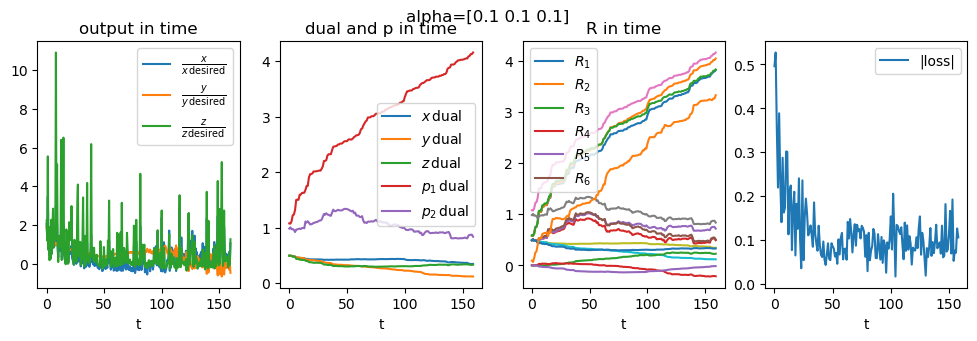

In [56]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0, \
                                                   use_p_tag=True, R_update=R_update)

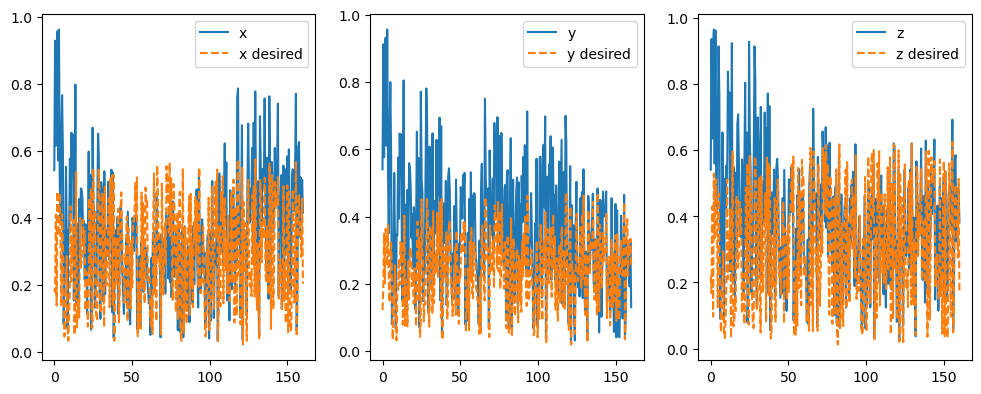

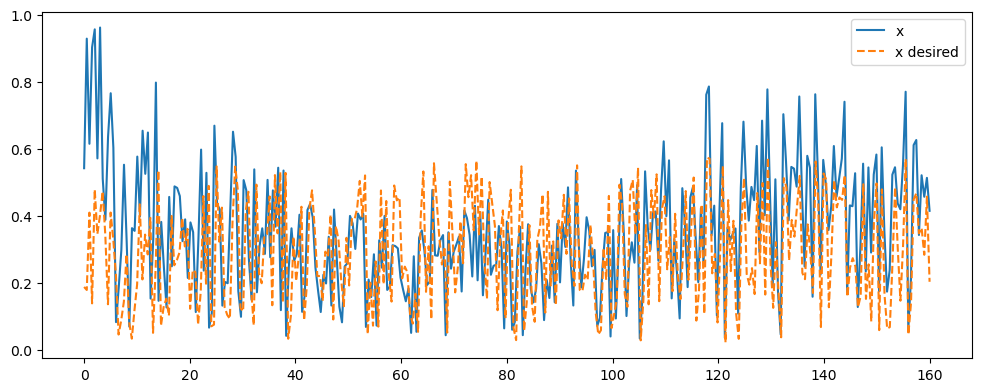

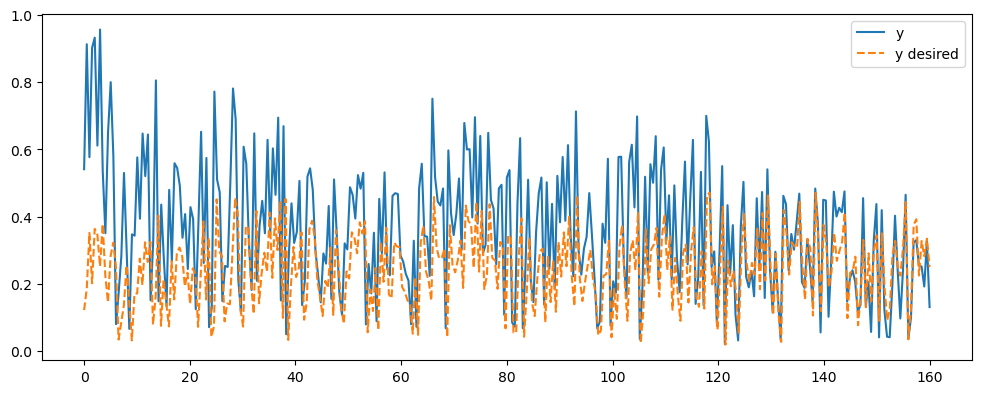

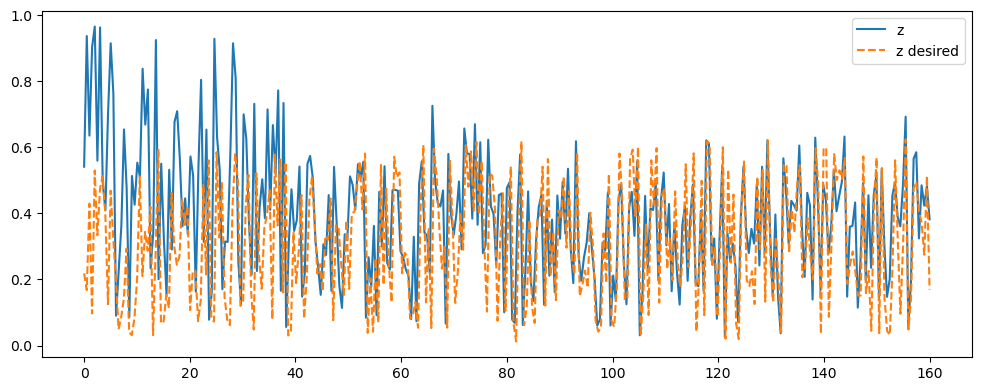

In [57]:
legends = [['x', 'x desired'], ['y', 'y desired'], ['z', 'z desired']]
if variabs.task_type=='Allostery':
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    for i in range(2):
        axes[i].plot(np.linspace(0, state.t, state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(desired[i]*np.ones(state.t).T, '--')
        axes[i].legend(legends[i])        
    for i in range(2):
        fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
        plt.plot(np.linspace(0, state.t, state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        plt.plot(desired[i]*np.ones(state.t).T, '--')
        plt.legend(legends[i])
elif variabs.task_type=='Regression':
    fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
    axes.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:])
    axes.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t), '--')
    axes.legend(legends[0])           
# regression goes only every two samples
elif task_type=='General_reg' or task_type=='General_reg_allRsChange':
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
    for i in range(3):
        axes[i].plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        axes[i].legend(legends[i])        
    for i in range(3):
        fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
        plt.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        plt.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        plt.legend(legends[i])

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.29367004
 0.29891456 0.26698682 0.24072879 0.22983681 0.21796326 0.20005905
 0.1981645  0.19184811 0.18309724 0.18000922 0.18560717 0.16898701
 0.14687974 0.15712581 0.14394889 0.13797963 0.14774991 0.14659847
 0.13831983 0.14279862 0.13868397 0.13745879 0.12446384 0.1313993
 0.13791447 0.12588823 0.12769086 0.12602306 0.11714417 0.10932188
 0.10520155 0.10336566 0.09687314 0.09123853 0.08971721 0.08195279
 0.07721824 0.0741044  0.07551984 0.07162151 0.07102546 0.07070383
 0.07147478 0.06724897 0.07109043 0.07307278 0.07629349 0.07826565
 0.07816161 0.08026789 0.07925585 0.07669941 0.08175598 0.08518359
 0.09162866 0.09770289 0.09523099 0.09888006 0.10146857 0.09904652
 0.10562852 0.10901906 0.11271993 0.11677156 0.11603594 0.11805354
 0.11559238 0.11084345 0.11412205 0.10730313 0.1056767  0.10291314
 0.09798164 0.09515519 0.09519088 0.0960854  0.08995949 0.08420

Text(0, 0.5, '$Loss$')

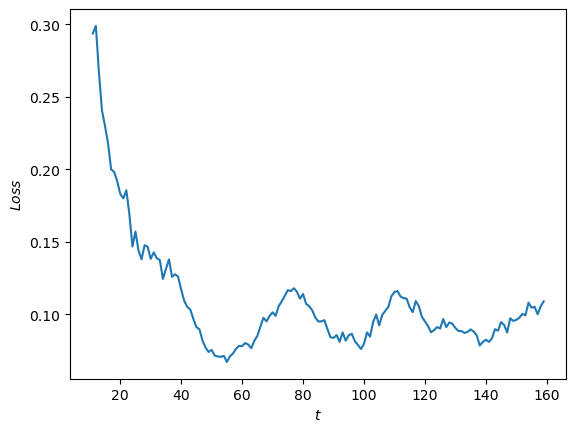

In [58]:
import pandas as pd

loss_1d_in_t = np.mean(np.mean(np.abs(state.loss_in_t), axis=1), axis=1)

# Convert the numpy array to a pandas Series
loss_series = pd.Series(loss_1d_in_t)

# Calculate the moving mean with a window size of 3
moving_mean = loss_series.rolling(window=12).mean()

# Convert back to numpy array if needed
moving_mean_array = moving_mean.to_numpy()

print(moving_mean_array)

# plt.plot(loss_1d_in_t)
plt.plot(moving_mean_array)
plt.xlabel('$t$')
plt.ylabel('$Loss$')

In [ ]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")

In [ ]:
def f(n: int) -> str:
    """Convert number to string.
    """
    return n